# Logistic Regression
### Data Mining Classification Project
by Rick Gosalvez, SV@Home, SJSU MSDA (rick@siliconvalleyathome.org) 

#### Are CA AFH State Tools Speeding Up Approvals? What is the Optimal Mix?

<li>Data from affordable and market rate developers and opensource.
<li>Use 3 methods to classify data.
<li>21 features

#### Libraries

In [1]:
import numpy as np
import pandas as pd
import pandas.testing as tm
import matplotlib.pyplot as plt
import scikitplot as skplt

from sklearn.preprocessing import StandardScaler       # Standardization of data
from sklearn.preprocessing import LabelEncoder         # Label > Number for analysis

from sklearn.metrics import plot_confusion_matrix      # pretty plot confusion matrix
from sklearn.model_selection import train_test_split   # Training/Test split

from sklearn.linear_model import LogisticRegression    # Logistic regression
import statsmodels.api as sm                           # Step model

from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.metrics import roc_curve 

#### Load data and preview

In [2]:
df = pd.read_csv('DATA_ML_Project_MFR_FINAL.csv', parse_dates=['Submitted','Approved'])
df.head()

,Dev,Name,Address,City,GP_COMPLY,Z_COMPLY,TOD,PLAN_AREA,DU,MKT,AFH,SB35,SB330,AB1763,AB2162,AB2345,AB2372,AB3194,Submitted,Approved
0,RCD,Madrone Terrace,60060 E 14th Street,Ashland,Y,Y,Y,N,79,1,79,Y,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-12,2019-11-13
1,NaN,Fourth Street,1900 Fourth Street,Berkeley,Y,Y,Y,Y,260,130,130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-03-08,2021-04-22
2,RCD,Maudelle Miller Shirek,2001 Ashby,Berkeley,Y,Y,Y,Y,87,1,86,Y,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-04,2019-12-20
3,NaN,Blake,2015 Blake,Berkeley,Y,Y,Y,Y,155,155,0,NaN,Y,NaN,NaN,NaN,NaN,NaN,2020-07-10,2021-03-18
4,NaN,Telegraph,3031 Telegraph,Berkeley,Y,N,N,N,110,110,0,NaN,Y,NaN,NaN,NaN,NaN,NaN,2020-08-05,2020-11-20


#### Clean and prepare data

In [3]:
# drop names

df.drop(columns=['Dev', 'Name','Address'], inplace=True)
df.head()

,City,GP_COMPLY,Z_COMPLY,TOD,PLAN_AREA,DU,MKT,AFH,SB35,SB330,AB1763,AB2162,AB2345,AB2372,AB3194,Submitted,Approved
0,Ashland,Y,Y,Y,N,79,1,79,Y,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-12,2019-11-13
1,Berkeley,Y,Y,Y,Y,260,130,130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-03-08,2021-04-22
2,Berkeley,Y,Y,Y,Y,87,1,86,Y,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-04,2019-12-20
3,Berkeley,Y,Y,Y,Y,155,155,0,NaN,Y,NaN,NaN,NaN,NaN,NaN,2020-07-10,2021-03-18
4,Berkeley,Y,N,N,N,110,110,0,NaN,Y,NaN,NaN,NaN,NaN,NaN,2020-08-05,2020-11-20


In [4]:
# Part_AFH (> 15% inclusionary AFH), All_AFH (Y/N)
df['All_AFH']  = df.AFH >= df.DU - 2
df['Part_AFH'] = df.AFH/df.DU >= 0.15
df

,City,GP_COMPLY,Z_COMPLY,TOD,PLAN_AREA,DU,MKT,AFH,SB35,SB330,AB1763,AB2162,AB2345,AB2372,AB3194,Submitted,Approved,All_AFH,Part_AFH
0,Ashland,Y,Y,Y,N,79,1,79,Y,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-12,2019-11-13,True,True
1,Berkeley,Y,Y,Y,Y,260,130,130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-03-08,2021-04-22,False,True
2,Berkeley,Y,Y,Y,Y,87,1,86,Y,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-04,2019-12-20,True,True
3,Berkeley,Y,Y,Y,Y,155,155,0,NaN,Y,NaN,NaN,NaN,NaN,NaN,2020-07-10,2021-03-18,False,False
4,Berkeley,Y,N,N,N,110,110,0,NaN,Y,NaN,NaN,NaN,NaN,NaN,2020-08-05,2020-11-20,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,Sunnyvale,Y,N,N,N,141,123,18,NaN,Y,NaN,NaN,NaN,NaN,NaN,2020-08-28,2021-02-26,False,False
108,Sunnyvale,Y,Y,Y,Y,28,24,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-02-17,NaT,False,False
109,Sunnyvale,Y,Y,Y,Y,35,30,5,NaN,Y,NaN,NaN,NaN,NaN,NaN,2021-03-05,NaT,False,False
110,Vallejo,Y,Y,N,N,75,1,74,Y,NaN,NaN,Y,NaN,NaN,NaN,2020-07-16,2020-10-29,True,True


In [5]:
# calculate days and cut-off, if < 180 days '1', else '0'
df['Days']         = df.Approved - df.Submitted
df['Streamlined']  = df['Days'].dt.days <= 180
df

,City,GP_COMPLY,Z_COMPLY,TOD,PLAN_AREA,DU,MKT,AFH,SB35,SB330,...,AB2162,AB2345,AB2372,AB3194,Submitted,Approved,All_AFH,Part_AFH,Days,Streamlined
0,Ashland,Y,Y,Y,N,79,1,79,Y,NaN,...,NaN,NaN,NaN,NaN,2019-08-12,2019-11-13,True,True,93 days,True
1,Berkeley,Y,Y,Y,Y,260,130,130,NaN,NaN,...,NaN,NaN,NaN,NaN,2018-03-08,2021-04-22,False,True,1141 days,False
2,Berkeley,Y,Y,Y,Y,87,1,86,Y,NaN,...,NaN,NaN,NaN,NaN,2019-10-04,2019-12-20,True,True,77 days,True
3,Berkeley,Y,Y,Y,Y,155,155,0,NaN,Y,...,NaN,NaN,NaN,NaN,2020-07-10,2021-03-18,False,False,251 days,False
4,Berkeley,Y,N,N,N,110,110,0,NaN,Y,...,NaN,NaN,NaN,NaN,2020-08-05,2020-11-20,False,False,107 days,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,Sunnyvale,Y,N,N,N,141,123,18,NaN,Y,...,NaN,NaN,NaN,NaN,2020-08-28,2021-02-26,False,False,182 days,False
108,Sunnyvale,Y,Y,Y,Y,28,24,4,NaN,NaN,...,NaN,NaN,NaN,NaN,2021-02-17,NaT,False,False,NaT,False
109,Sunnyvale,Y,Y,Y,Y,35,30,5,NaN,Y,...,NaN,NaN,NaN,NaN,2021-03-05,NaT,False,False,NaT,False
110,Vallejo,Y,Y,N,N,75,1,74,Y,NaN,...,Y,NaN,NaN,NaN,2020-07-16,2020-10-29,True,True,105 days,True


In [6]:
# drop unused columns
df.drop(columns=['Submitted', 'Approved','Days'], inplace=True)
df.head()

,City,GP_COMPLY,Z_COMPLY,TOD,PLAN_AREA,DU,MKT,AFH,SB35,SB330,AB1763,AB2162,AB2345,AB2372,AB3194,All_AFH,Part_AFH,Streamlined
0,Ashland,Y,Y,Y,N,79,1,79,Y,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True
1,Berkeley,Y,Y,Y,Y,260,130,130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,False
2,Berkeley,Y,Y,Y,Y,87,1,86,Y,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True
3,Berkeley,Y,Y,Y,Y,155,155,0,NaN,Y,NaN,NaN,NaN,NaN,NaN,False,False,False
4,Berkeley,Y,N,N,N,110,110,0,NaN,Y,NaN,NaN,NaN,NaN,NaN,False,False,True


In [7]:
# filling in NaN with 0
df["SB35"].fillna(0, inplace = True)
df["SB330"].fillna(0, inplace = True)
df["AB1763"].fillna(0, inplace = True)
df["AB2162"].fillna(0, inplace = True)
df["AB2345"].fillna(0, inplace = True)
df["AB2372"].fillna(0, inplace = True)
df["AB3194"].fillna(0, inplace = True)
df.head()

,City,GP_COMPLY,Z_COMPLY,TOD,PLAN_AREA,DU,MKT,AFH,SB35,SB330,AB1763,AB2162,AB2345,AB2372,AB3194,All_AFH,Part_AFH,Streamlined
0,Ashland,Y,Y,Y,N,79,1,79,Y,0,0,0,0,0.0,0,True,True,True
1,Berkeley,Y,Y,Y,Y,260,130,130,0,0,0,0,0,0.0,0,False,True,False
2,Berkeley,Y,Y,Y,Y,87,1,86,Y,0,0,0,0,0.0,0,True,True,True
3,Berkeley,Y,Y,Y,Y,155,155,0,0,Y,0,0,0,0.0,0,False,False,False
4,Berkeley,Y,N,N,N,110,110,0,0,Y,0,0,0,0.0,0,False,False,True


In [8]:
# converting 'AB2372' from float to int
df['AB2372'] = df['AB2372'].astype(int)
df.head()

,City,GP_COMPLY,Z_COMPLY,TOD,PLAN_AREA,DU,MKT,AFH,SB35,SB330,AB1763,AB2162,AB2345,AB2372,AB3194,All_AFH,Part_AFH,Streamlined
0,Ashland,Y,Y,Y,N,79,1,79,Y,0,0,0,0,0,0,True,True,True
1,Berkeley,Y,Y,Y,Y,260,130,130,0,0,0,0,0,0,0,False,True,False
2,Berkeley,Y,Y,Y,Y,87,1,86,Y,0,0,0,0,0,0,True,True,True
3,Berkeley,Y,Y,Y,Y,155,155,0,0,Y,0,0,0,0,0,False,False,False
4,Berkeley,Y,N,N,N,110,110,0,0,Y,0,0,0,0,0,False,False,True


In [9]:
# converting 'Streamlined' boolean to int
df['All_AFH'] = df.apply(lambda row: row['All_AFH'] == True, axis=1).astype(int)
df['Part_AFH'] = df.apply(lambda row: row['Part_AFH'] == True, axis=1).astype(int)
df['Streamlined'] = df.apply(lambda row: row['Streamlined'] == True, axis=1).astype(int)
df.head()

,City,GP_COMPLY,Z_COMPLY,TOD,PLAN_AREA,DU,MKT,AFH,SB35,SB330,AB1763,AB2162,AB2345,AB2372,AB3194,All_AFH,Part_AFH,Streamlined
0,Ashland,Y,Y,Y,N,79,1,79,Y,0,0,0,0,0,0,1,1,1
1,Berkeley,Y,Y,Y,Y,260,130,130,0,0,0,0,0,0,0,0,1,0
2,Berkeley,Y,Y,Y,Y,87,1,86,Y,0,0,0,0,0,0,1,1,1
3,Berkeley,Y,Y,Y,Y,155,155,0,0,Y,0,0,0,0,0,0,0,0
4,Berkeley,Y,N,N,N,110,110,0,0,Y,0,0,0,0,0,0,0,1


In [10]:
# convert Y and N to 1 and 0 (binary)
df = df.replace(['Y'],1)
df = df.replace(['N'],0)
df.head()

,City,GP_COMPLY,Z_COMPLY,TOD,PLAN_AREA,DU,MKT,AFH,SB35,SB330,AB1763,AB2162,AB2345,AB2372,AB3194,All_AFH,Part_AFH,Streamlined
0,Ashland,1,1,1,0,79,1,79,1,0,0,0,0,0,0,1,1,1
1,Berkeley,1,1,1,1,260,130,130,0,0,0,0,0,0,0,0,1,0
2,Berkeley,1,1,1,1,87,1,86,1,0,0,0,0,0,0,1,1,1
3,Berkeley,1,1,1,1,155,155,0,0,1,0,0,0,0,0,0,0,0
4,Berkeley,1,0,0,0,110,110,0,0,1,0,0,0,0,0,0,0,1


### 2. Split input and output

In [11]:
# 17 input features (data attributes). Remove city; NOT numeric.
X = df.loc[:,['DU', 'MKT', 'AFH', 'GP_COMPLY', 'Z_COMPLY', 'TOD', 'PLAN_AREA', 'SB35',
       'SB330', 'AB1763', 'AB2162', 'AB2345', 'AB2372', 'AB3194', 'All_AFH',
       'Part_AFH']]
X.keys()

Index(['DU', 'MKT', 'AFH', 'GP_COMPLY', 'Z_COMPLY', 'TOD', 'PLAN_AREA', 'SB35',
       'SB330', 'AB1763', 'AB2162', 'AB2345', 'AB2372', 'AB3194', 'All_AFH',
       'Part_AFH'],
      dtype='object')

In [12]:
# outcome/output
y=df['Streamlined']

In [13]:
class_le = LabelEncoder()
y = class_le.fit_transform(y)
y

array([1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1])

In [14]:
# normalize all non-binary features (e.g.'DU', 'MKT','AFH')

stdsc = StandardScaler()
X.iloc[:,[0,1,2]] = stdsc.fit_transform(X.iloc[:,[0,1,2]])
#X['Intercept'] = 1     # if set intercept before, removes warning, but not recommended, changes logistic regression!!!
X.head()

,DU,MKT,AFH,GP_COMPLY,Z_COMPLY,TOD,PLAN_AREA,SB35,SB330,AB1763,AB2162,AB2345,AB2372,AB3194,All_AFH,Part_AFH
0,-0.352965,-0.496316,0.028307,1,1,1,0,1,0,0,0,0,0,0,1,1
1,0.314072,0.165378,0.450479,1,1,1,1,0,0,0,0,0,0,0,0,1
2,-0.323483,-0.496316,0.086252,1,1,1,1,1,0,0,0,0,0,0,1,1
3,-0.072883,0.293613,-0.625644,1,1,1,1,0,1,0,0,0,0,0,0,0
4,-0.238721,0.062789,-0.625644,1,0,0,0,0,1,0,0,0,0,0,0,0


#### Check dataframe for null values

In [15]:
df.isnull().values.any()

False

### 3. Split into test and training

<b>NOTE:</b> 
* Tested setting test_size @ 15% and 20%. 15% worked better with smaller dataset (dataset < 75) so model had more to train from; however, 20% worked well after increasing dataset > 100 data points and this is expected to improve with data.
* Tested L1 vs L2 (default) penalty. L1 generated low accuracy and random_state affected ROC AUC. 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)  # increase training size can improve accuracy of smaller datasets. 

In [17]:
logistic = LogisticRegression(solver='liblinear', random_state=1) # good optimizer for smaller datasets
# logistic = LogisticRegression() 
logistic.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [18]:
y_pred = logistic.predict(X_test) 

In [19]:
print(f'Model Accuracy Score: {accuracy_score(y_test,y_pred)}')

Model Accuracy Score: 0.7391304347826086


In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        15
           1       1.00      0.25      0.40         8

    accuracy                           0.74        23
   macro avg       0.86      0.62      0.62        23
weighted avg       0.81      0.74      0.68        23



### 4. Confusion Matrix

In [21]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index  =['True[0]','True[1]'],
                      columns=['Predict[0]','Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],15,0
True[1],6,2


### 5. Draw ROC Curve and cumulative gain chart

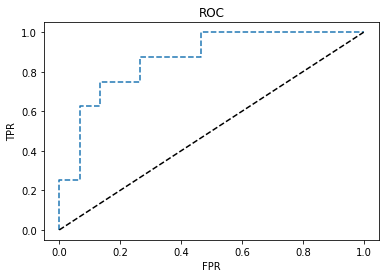

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, logistic.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, '--', label="Logistic Regression")
plt.plot([0,1],[0,1],'k--', label='Random Guess')
plt.plot([fpr],[tpr], 'r-', ms=10)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()

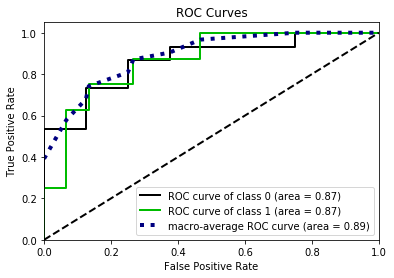

In [23]:
skplt.metrics.plot_roc(y_test, logistic.predict_proba(X_test), plot_micro=False)
plt.show()

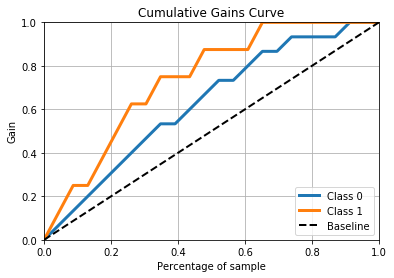

In [24]:
skplt.metrics.plot_cumulative_gain(y_test, logistic.predict_proba(X_test))
plt.show()

### 6. Use sm.logit with "intercept=1" to check coefficients

In [25]:
# Set intercept after split
X['Intercept'] = 1  

In [26]:
# Ensure no singularity matrix (1:1 correlations between columns except with self)
n = len(X)
X = X+0.001*np.random.rand(n, 17)

In [27]:
# Check correlations
X.corr()

,DU,MKT,AFH,GP_COMPLY,Z_COMPLY,TOD,PLAN_AREA,SB35,SB330,AB1763,AB2162,AB2345,AB2372,AB3194,All_AFH,Part_AFH,Intercept
DU,1.000000,0.915884,0.749496,-0.190096,-0.133457,0.014094,0.074211,0.080584,0.212465,-0.067059,-0.068307,0.111114,-0.026054,-0.002583,-0.292604,-0.116357,0.065880
MKT,0.915884,1.000000,0.423170,-0.147394,-0.115496,0.046272,0.136696,-0.055016,0.211691,-0.118131,-0.118420,0.011344,-0.032386,0.045966,-0.516374,-0.403017,0.073037
AFH,0.749496,0.423170,1.000000,-0.183569,-0.116514,-0.045719,-0.056753,0.275533,0.139376,0.042881,0.040492,0.236152,-0.010107,-0.077644,0.189013,0.395460,0.020736
GP_COMPLY,-0.190096,-0.147394,-0.183569,1.000000,0.379435,0.162740,0.245371,-0.007640,-0.041999,-0.009842,-0.009869,0.030525,0.129590,-0.052713,0.089869,-0.042143,-0.178816
Z_COMPLY,-0.133457,-0.115496,-0.116514,0.379435,1.000000,-0.011220,0.198334,0.014850,0.023755,-0.109730,-0.030070,-0.051364,0.121471,-0.121229,-0.058680,-0.135501,-0.044185
TOD,0.014094,0.046272,-0.045719,0.162740,-0.011220,1.000000,0.385062,0.031113,-0.028127,0.137971,-0.021226,0.014579,0.169605,0.079439,0.122424,0.055364,-0.188757
PLAN_AREA,0.074211,0.136696,-0.056753,0.245371,0.198334,0.385062,1.000000,-0.049534,0.012492,-0.119060,-0.119222,0.088551,0.220214,-0.031440,-0.132479,-0.143255,-0.113067
SB35,0.080584,-0.055016,0.275533,-0.007640,0.014850,0.031113,-0.049534,1.000000,0.025163,0.315158,-0.001750,0.223440,-0.042815,0.041197,0.245890,0.273351,-0.012534
SB330,0.212465,0.211691,0.139376,-0.041999,0.023755,-0.028127,0.012492,0.025163,1.000000,-0.074293,0.064483,0.140744,0.000904,0.277191,-0.261713,-0.254311,0.175143
AB1763,-0.067059,-0.118131,0.042881,-0.009842,-0.109730,0.137971,-0.119060,0.315158,-0.074293,1.000000,0.295791,0.016460,0.120395,0.168022,0.229392,0.194838,0.073207


In [28]:
logistic_ml   = sm.Logit(y, X)

In [29]:
logistic_coef = logistic_ml.fit()
logistic_coef.summary2()

Optimization terminated successfully.
         Current function value: 0.334638
         Iterations 11


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.370     
Dependent Variable: y                AIC:              108.9588  
Date:               2021-05-16 10:28 BIC:              155.1733  
No. Observations:   112              Log-Likelihood:   -37.479   
Df Model:           16               LL-Null:          -59.466   
Df Residuals:       95               LLR p-value:      0.00019911
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     11.0000                                      
-----------------------------------------------------------------
            Coef.    Std.Err.    z    P>|z|    [0.025     0.975] 
-----------------------------------------------------------------
DU          -5.3112   36.8267 -0.1442 0.8853   -77.4903   66.8678
MKT          4.0283   26.5436  0.1518 0.8794   -47.9962   56.0527
AFH          2.4113   16.3573  0.1474 0.8828   -29.6484   34.4711
GP_COMPLY    0.3601    1.0579  0.3404 0.7336    -1.7134    2.4336
Z_COMPLY     0.3324    0.6928  0.4799 0.6313    -1.0253    1.6902
TOD         -0.4247    0.7257 -0.5852 0.5584    -1.8470    0.9977
PLAN_AREA   -2.0935    0.7578 -2.7627 0.0057    -3.5788   -0.6083
SB35         2.5222    0.7957  3.1696 0.0015     0.9626    4.0818
SB330        2.5123    1.0670  2.3545 0.0185     0.4210    4.6036
AB1763       0.1671    1.2400  0.1348 0.8928    -2.2632    2.5975
AB2162      -2.1140    1.4289 -1.4794 0.1390    -4.9146    0.6867
AB2345       1.2647    0.7984  1.5840 0.1132    -0.3001    2.8295
AB2372     987.4796 1083.3277  0.9115 0.3620 -1135.8038 3110.7629
AB3194       1.0518    1.7445  0.6029 0.5466    -2.3673    4.4709
All_AFH      3.9644    4.0707  0.9739 0.3301    -4.0141   11.9430
Part_AFH    -2.7425    4.3004 -0.6377 0.5236   -11.1711    5.6860
Intercept   -2.7886    1.3627 -2.0465 0.0407    -5.4594   -0.1179
=================================================================

"""

### 7. Calculate Odds Ratio (OR) for each input feature for unit change=1

In [30]:
np.exp(logistic_coef.params)

/Users/gosalvez/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


DU            0.004936
MKT          56.163740
AFH          11.148627
GP_COMPLY     1.433471
Z_COMPLY      1.394337
TOD           0.653984
PLAN_AREA     0.123251
SB35         12.456150
SB330        12.333208
AB1763        1.181931
AB2162        0.120760
AB2345        3.541939
AB2372             inf
AB3194        2.862780
All_AFH      52.690846
Part_AFH      0.064407
Intercept     0.061504
dtype: float64

### 8. Choose input features based on 90% confidence level (P < 0.1); Eliminate 'No Impact' Features; Apply Domain

Redo classification via LogisticRegression in sckitlearn with same parameter set. 

Selected Conf. Lvl based on domain laws significant for streamlining. 

Upon visual inspection; the following are 4 features are <b>statistically significant</b>. One feature is noises AB2372. One feature is a density bonus law which are commonly used for affordable housing developments AB 2345, but should not affect streamlining; however, happen to coincide with streamline eligible projects. One feature is a streamlining law AB2162, that based on training data seems to have not been included, but we will include due to having domain knowledge.

The final list of features is:
* PLAN_AREA
* SB35
* SB330
* AB2162
* AB2345

In [31]:
# X = Input feature (features: Income, Family, Education, CDAccount, CreditCard)
X = X.drop(['DU','MKT','AFH','GP_COMPLY','Z_COMPLY','TOD','AB1763','AB2372','AB3194','All_AFH','Part_AFH'], axis=1)
X.head()

,PLAN_AREA,SB35,SB330,AB2162,AB2345,Intercept
0,0.000027,1.000885,0.000556,0.000073,0.000982,1.000769
1,1.000487,0.000913,0.000805,0.000980,0.000386,1.000323
2,1.000117,1.000308,0.000300,0.000721,0.000561,1.000605
3,1.000153,0.000221,1.000537,0.000546,0.000250,1.000816
4,0.000307,0.000777,1.000458,0.000985,0.000573,1.000571


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [33]:
logistic = LogisticRegression(solver='liblinear', random_state=1) # good optimizer for smaller datasets
# logistic = LogisticRegression() 
logistic.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [34]:
y_pred = logistic.predict(X_test)

In [35]:
print(f'Model Accuracy Score: {accuracy_score(y_test,y_pred)}')

Model Accuracy Score: 0.8695652173913043


In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93        20
           1       0.50      0.33      0.40         3

    accuracy                           0.87        23
   macro avg       0.70      0.64      0.66        23
weighted avg       0.85      0.87      0.86        23



In [37]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index  =['True[0]','True[1]'],
                      columns=['Predict[0]','Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],19,1
True[1],2,1


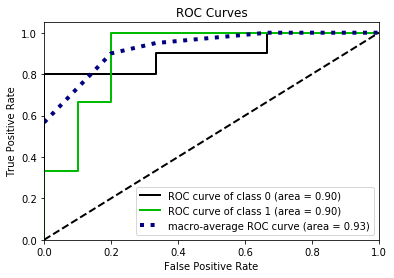

In [38]:
skplt.metrics.plot_roc(y_test, logistic.predict_proba(X_test), plot_micro=False)
plt.show()

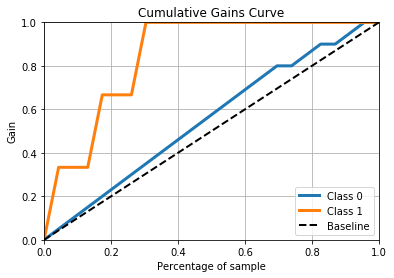

In [39]:
skplt.metrics.plot_cumulative_gain(y_test, logistic.predict_proba(X_test))
plt.show()

In [40]:
logistic_ml   = sm.Logit(y_train, X_train)

In [41]:
logistic_coef = logistic_ml.fit()
logistic_coef.summary2()

Optimization terminated successfully.
         Current function value: 0.382146
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.317     
Dependent Variable: y                AIC:              80.0219   
Date:               2021-05-16 10:28 BIC:              94.9537   
No. Observations:   89               Log-Likelihood:   -34.011   
Df Model:           5                LL-Null:          -49.771   
Df Residuals:       83               LLR p-value:      7.3915e-06
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
PLAN_AREA     -1.9734    0.6962  -2.8345  0.0046  -3.3380  -0.6089
SB35           2.8247    0.7496   3.7684  0.0002   1.3555   4.2938
SB330          2.1294    0.9530   2.2344  0.0255   0.2616   3.9972
AB2162        -1.2970    1.3303  -0.9749  0.3296  -3.9044   1.3104
AB2345         1.0765    0.7920   1.3592  0.1741  -0.4758   2.6288
Intercept     -1.2652    0.4557  -2.7766  0.0055  -2.1583  -0.3721
=================================================================

"""

In [42]:
np.exp(logistic_coef.params)

PLAN_AREA     0.138978
SB35         16.855575
SB330         8.409819
AB2162        0.273362
AB2345        2.934372
Intercept     0.282187
dtype: float64

# Analysis

Odds Ratio of SB35 is as expected; however AB2162 is not in alignment with domain expectations. AB2162 is a streamlining bill and should never have a negative coefficient (e.g. negatively impact if a project is streamlined or not). AB2345, in theory, is not expected to influence approval times. More data needed.

Accuracy improved as features are selected and reduced; however, due to limited dataset training data <b>SIGNIFICANTLY AFFECTED</b> model. <u>Larger dataset needed for more reliable model.</u>

For the logistic regression model, with this dataset, domain knowledge is required to guide model. 

# 3 Classification Model Comparison Conclusion

All optimized models resulted in accuracies ranging from 78% to 91% and macro average ROC AUC from 78% to 93%.

The <u>best model</u> is the <b><u>Logistic Regression Classifier</u></b>, which offers the highest accuracy at 87% and a macro average receiver operating characteristic (ROC) area under the curve (AUC) [True Positives vs False Positives] of 93% for this iteration; however, reliability of the model fluctuates greatly based on the model's training dataset. A larger dataset is expected to help stabilize the models results. 

The <u>most reliable (consistent) model </u> based on current dataset and domain knowledge is the <b><u>Decision Tree Classifier</u></b>, which offers the highest accuracy at 83% and a macro average receiver operating characteristic (ROC) area under the curve (AUC) [True Positives vs False Positives] of 88%.

That said, as data becomes available, these models are poised for use and can be re-run to compare as future datasets grow and become available.